# Probability

## Hot Hands

Basketball players who make several baskets in succession are described as having a hot hand. Fans and players have long believed in the hot hand phenomenon, which refutes the assumption that each shot is independent of the next. However, a 1985 [paper](https://www.cs.colorado.edu/~mozer/Teaching/syllabi/7782/readings/gilovich%20vallone%20tversky.pdf) by Gilovich, Vallone, and Tversky collected evidence that contradicted this belief and showed that successive shots are independent events. This paper started a great controversy that continues to this day, as you can see by Googling hot hand basketball.

We do not expect to resolve this controversy today. However, in this lab we'll apply one approach to answering questions like this. The goals for this lab are to (1) think about the effects of independent and dependent events, (2) learn how to simulate shooting streaks in Python, and (3) to compare a simulation to actual data in order to determine if the hot hand phenomenon appears to be real.

In [1]:
# for Mac OS users only!
# if you run into any SSL certification issues, 
# you may need to run the following command for a Mac OS installation.
# $/Applications/Python 3.x/Install Certificates.command
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

## Getting started

Our investigation will focus on the performance of one player: Kobe Bryant of the Los Angeles Lakers. His performance against the Orlando Magic in the 2009 NBA finals earned him the title Most Valuable Player and many spectators commented on how he appeared to show a hot hand. Let's load some data from those games and look at the first several rows.

In [2]:
import pandas as pd

kobe = pd.read_csv('https://www.openintro.org/stat/data/kobe.csv')
kobe.head()

,vs,game,quarter,time,description,basket
0,ORL,1,1,9:47,Kobe Bryant makes 4-foot two point shot,H
1,ORL,1,1,9:07,Kobe Bryant misses jumper,M
2,ORL,1,1,8:11,Kobe Bryant misses 7-foot jumper,M
3,ORL,1,1,7:41,Kobe Bryant makes 16-foot jumper (Derek Fisher...,H
4,ORL,1,1,7:03,Kobe Bryant makes driving layup,H


_**Remark.** Observe, as in the previous lab, that the data does not immediately assume, right from reading the .csv file, a form which pandas recognizes as categorical._

In [3]:
kobe.dtypes

vs             object
game            int64
quarter        object
time           object
description    object
basket         object
dtype: object

_Some of the `object`-dtype columns in our dataframe represent values that would be more suitable to work with as categorical data (since, in fact, they can only conceivably assume one of a limited set of values.)_

_[Adding a column to a dataframe is relatively fast](https://pandas.pydata.org/docs/user_guide/10min.html#concat), so we'll take the liberty of doing that to illustrate what we're after:_

In [4]:
# Make a column for categorical 'vs'
kobe['vs_cat'] = kobe['vs'].astype('category')

# >>> kobe['vs_cat']
# [...]
# Name: vs_cat, Length: 133, dtype: category
# Categories (1, object): [ORL]

# Make a column for categorical 'basket'
kobe['basket_cat'] = kobe['basket'].astype('category')

# >>> kobe['basket_cat']
# [...]
# Name: basket_cat, Length: 133, dtype: category
# Categories (2, object): [H, M]

_Meanwhile, the `description` column appears to contain natural-language descriptions for each shot taken, so we might just get a new value for every row. We won't bother making a categorical version for this right now. And the `quarter`, `time` columns have to do with the passage of time (periods of time or minutes / seconds), so shouldn't be dealt with as categorical data._

In this data frame, every row records a shot taken by Kobe Bryant. If he hit the shot (made a basket), a hit, `H`, is recorded in the column named basket, otherwise a miss, `M`, is recorded.

Just looking at the string of hits and misses, it can be difficult to gauge whether or not it seems like Kobe was shooting with a hot hand. One way we can approach this is by considering the belief that hot hand shooters tend to go on shooting streaks. For this lab, we define the length of a shooting streak to be the ***number of consecutive baskets made until a miss occurs***.

For example, in Game 1 Kobe had the following sequence of hits and misses from his nine shot attempts in the first quarter:

##### `H M | M | H H M | M | M | M`

To verify this use the following command:

In [5]:
kobe['basket'][0:9]

0    H
1    M
2    M
3    H
4    H
5    M
6    M
7    M
8    M
Name: basket, dtype: object

Within the nine shot attempts, there are six streaks, which are separated by a "|" above. Their lengths are one, zero, two, zero, zero, zero (in order of occurrence).

<div class = 'exercise'>
<h4>Exercise 1</h4>
What does a streak length of 1 mean, i.e. how many hits and misses are in a streak of 1? What about a streak length of 0?
</div>

_A streak length of 1 indicates a single hit ('H') following a miss (... 'M'), then followed by a miss concluding the streak:_

##### `... M | H M | ...`

_Meanwhile, a streak length of 0 indicates zero hits - a solitary miss ('M') directly preceded by a miss ('M'):_

##### `... M | M | ...`

_(If the 'M' in the middle were to have been preceded directly by an 'H' instead, then it would belong to a streak of length one or more.)_

The custom function `calc_streak()` can be used to calculate the lengths of all shooting streaks.

In [6]:
def calc_streak(x):
    all_shoots = list(x)
    streak, count = [], 0
    
    for shoot in all_shoots:
        if shoot == 'H':
            count += 1
        elif shoot == 'M':
            streak.append(count)
            count = 0
    
    # If the last shoot is a hit, make sure to append the last count to the streak list as well.
    if all_shoots[-1] == 'H':  
        streak.append(count)
        
    return streak  
    
kobe_streak = calc_streak(kobe['basket'])
print(kobe_streak)

[1, 0, 2, 0, 0, 0, 3, 2, 0, 3, 0, 1, 3, 0, 0, 0, 0, 0, 1, 1, 0, 4, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 3, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 3, 3, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]


We can look at the distribution of the lengths of all shooting streaks  with a barplot.

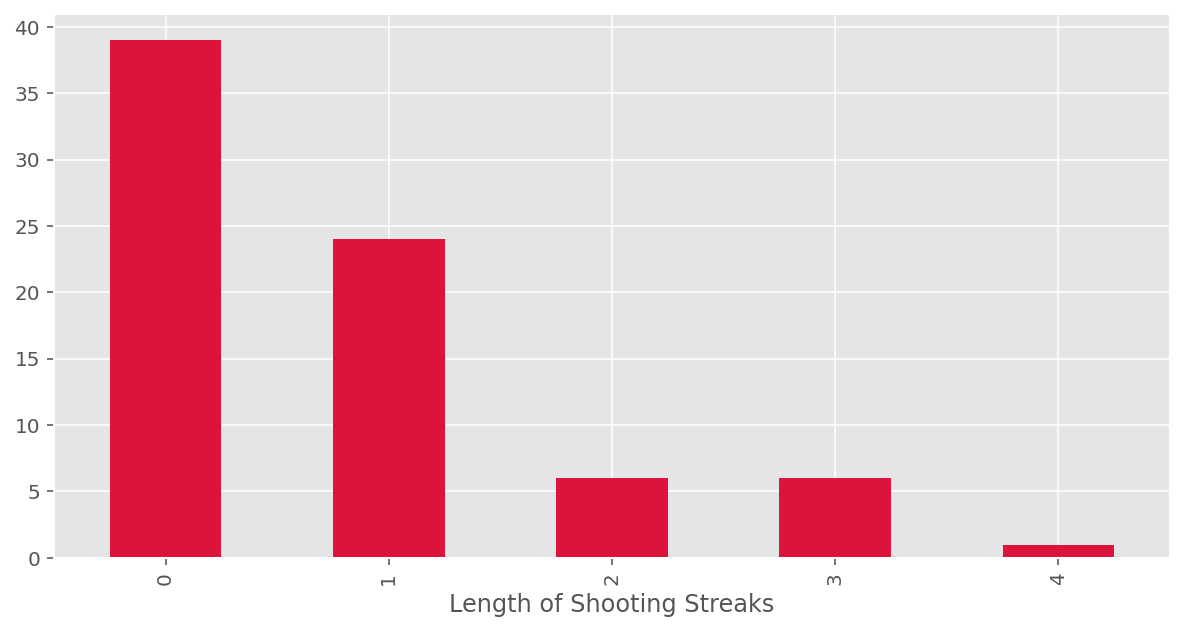

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,5)

kobe_streak_counts = pd.Series(kobe_streak).value_counts().sort_index()

kobe_streak_counts.plot(kind = 'bar', color = 'crimson')
plt.xlabel('Length of Shooting Streaks')
plt.show(); 

Note that instead of making a histogram, we chose to make a bar plot. A bar plot is preferable here since our variable is discrete – counts – instead of continuous.

<div class = 'exercise'>
<h4>Exercise 2</h4>
Describe the distribution of Kobe's streak lengths from the 2009 NBA finals. What was his typical streak length? How long was his longest streak of baskets?
</div>

_This is a unimodal distribution with a right tail, i.e. a distribution that is right skewed. The typical streak length was zero, while the longest streak of baskets observed was four._

## Compared to What?

We've shown that Kobe had some long shooting streaks, but are they long enough to support the belief that he had hot hands? What can we compare them to?

To answer these questions, let's return to the idea of *independence*. Two processes are independent if the outcome of one process doesn't effect the outcome of the second. If each shot that a player takes is an independent process, having made or missed your first shot will not affect the probability that you will make or miss your second shot.

A shooter with a hot hand will have shots that are *not* independent of one another. Specifically, if the shooter makes his first shot, the hot hand model says he will have a *higher* probability of making his second shot.

Let's suppose for a moment that the hot hand model is valid for Kobe. During his career, the percentage of time Kobe makes a basket (i.e. his shooting percentage) is about 45%, or in probability notation,
#### `P(shot 1 = H) = 0.45`
If he makes the first shot and has a hot hand (not independent shots), then the probability that he makes his second shot would go up to, let's say, 60%,
#### `P(shot 2 = H|shot 1 = H) = 0.60`
As a result of these increased probabilites, you'd expect Kobe to have longer streaks. Compare this to the skeptical perspective where Kobe does *not* have a hot hand (where each shot is independent of the next). If he hit his first shot, the probability that he makes the second is still 0.45.
#### `P(shot 2 = H|shot 1 = H) = 0.45`
In other words, making the first shot did nothing to effect the probability that he'd make his second shot. If Kobe's shots are independent, then he'd have the same probability of hitting every shot regardless of his past shots: 45%.

Now that we've phrased the situation in terms of independent shots, let's return to the question: how do we tell if Kobe's shooting streaks are long enough to indicate that he has hot hands? We can compare his streak lengths to someone without hot hands: an independent shooter.

## Simulations in Python

While we don't have any data from a shooter we know to have independent shots, that sort of data is very easy to simulate in Python. In a simulation, you set the ground rules of a random process and then the computer uses random numbers to generate an outcome that adheres to those rules. As a simple example, you can simulate flipping a fair coin with the following:

In [8]:
import numpy as np

outcomes = np.array(['heads', 'tails'])
print(np.random.choice(outcomes))

tails


The vector `outcomes` can be thought of as a hat with two slips of paper in it: one slip says `heads` and the other says `tails`. The function `random.choice()` draws one slip from the hat and tells us if it was a head or a tail.

Run the second command listed above several times. Just like when flipping a coin, sometimes you'll get a heads, sometimes you'll get a tails, but in the long run, you'd expect to get roughly equal numbers of each.

If you wanted to simulate flipping a fair coin 100 times, you could either run the function 100 times or, more simply, adjust the `size` argument, which governs how many samples to draw (the `replace = True` argument indicates we put the slip of paper back in the hat before drawing again). Save the resulting array of heads and tails in a new object called sim_fair_coin.

In [9]:
# random selection from 'outcomes', *with replacement* i.e. 'replace=True'
sim_fair_coin = np.random.choice(outcomes, size = 100, replace = True)

To view the results of this simulation, use `unique()` to count up the number of heads and tails:

In [10]:
unique, counts = np.unique(sim_fair_coin, return_counts = True)
print(np.asarray((unique, counts)).T)

[['heads' '50']
 ['tails' '50']]


Since there are only two elements in `outcomes`, the probability that we "flip" a coin and it lands heads is 0.5. Say we're trying to simulate an unfair coin that we know only lands heads 20% of the time. We can adjust for this by adding an argument called `p`, which provides the probabilities associated with each entry in the array.

In [11]:
sim_unfair_coin = np.random.choice(outcomes, size = 100, replace = True, p = [0.2, 0.8])
unique, counts = np.unique(sim_unfair_coin, return_counts = True)
print(np.asarray((unique, counts)).T)

[['heads' '20']
 ['tails' '80']]


`p = [0.2, 0.8]` indicates that for the two elements in the outcomes array, we want to select the first one, `heads` with probability 0.2 and the second one, `tails` with probability 0.8. Another way of thinking about this is to think of the outcome space as a bag of 10 chips, where 2 chips are labeled "head" and 8 chips "tail". Therefore at each draw, the probability of drawing a chip that says "head" is 20%, and "tail" is 80%.

<div class = 'exercise'>
<h4>Exercise 3</h4>
In your simulation of flipping the unfair coin 100 times, how many flips came up heads?
</div>

_Ran cell [25] above, to get a fresh set of results. In my simulation of flipping the unfair coin 100 times, only 23 flips out of those came up 'heads'._

In a sense, we've shrunken the size of the slip of paper that says "heads", making it less likely to be drawn and we've increased the size of the slip of paper saying "tails", making it more likely to be drawn. When we simulated the fair coin, both slips of paper were the same size. This happens by default if you don't provide a `p` argument; all elements in the `outcomes` array have an equal probability of being drawn.

## Simulating the Independent Shooter

Simulating a basketball player who has independent shots uses the same mechanism that we use to simulate a coin flip. To make a valid comparison between Kobe and our simulated independent shooter, we need to align both their shooting percentage and the number of attempted shots.

In [12]:
outcomes = np.array(['H', 'M'])
sim_basket = np.random.choice(outcomes, size = 133, replace = True, p = [0.45, 0.55])

With the results of the simulation saved as `sim_basket`, we have the data necessary to compare Kobe to our independent shooter. We can look at Kobe's data alongside our simulated data.

In [13]:
print(np.array(kobe['basket']))

['H' 'M' 'M' 'H' 'H' 'M' 'M' 'M' 'M' 'H' 'H' 'H' 'M' 'H' 'H' 'M' 'M' 'H'
 'H' 'H' 'M' 'M' 'H' 'M' 'H' 'H' 'H' 'M' 'M' 'M' 'M' 'M' 'M' 'H' 'M' 'H'
 'M' 'M' 'H' 'H' 'H' 'H' 'M' 'H' 'M' 'M' 'H' 'M' 'M' 'H' 'M' 'M' 'H' 'M'
 'H' 'H' 'M' 'M' 'H' 'M' 'H' 'H' 'M' 'H' 'M' 'M' 'M' 'H' 'M' 'M' 'M' 'M'
 'H' 'M' 'H' 'M' 'M' 'H' 'M' 'M' 'H' 'H' 'M' 'M' 'M' 'M' 'H' 'H' 'H' 'M'
 'M' 'H' 'M' 'M' 'H' 'M' 'H' 'H' 'M' 'H' 'M' 'M' 'H' 'M' 'M' 'M' 'H' 'M'
 'H' 'H' 'H' 'M' 'H' 'H' 'H' 'M' 'H' 'M' 'H' 'M' 'M' 'M' 'M' 'M' 'M' 'H'
 'M' 'H' 'M' 'M' 'M' 'M' 'H']


In [14]:
print(sim_basket)  # Notice that every time you rerun the simulation above, the results of sim_basket changes.

['H' 'M' 'H' 'M' 'M' 'M' 'M' 'M' 'H' 'H' 'H' 'M' 'M' 'M' 'M' 'H' 'M' 'M'
 'H' 'H' 'H' 'H' 'M' 'M' 'M' 'H' 'M' 'M' 'H' 'M' 'H' 'H' 'M' 'M' 'H' 'M'
 'H' 'M' 'H' 'H' 'M' 'M' 'M' 'M' 'H' 'H' 'H' 'H' 'H' 'M' 'H' 'M' 'M' 'H'
 'M' 'H' 'M' 'H' 'H' 'H' 'H' 'H' 'H' 'M' 'M' 'M' 'M' 'M' 'M' 'H' 'M' 'M'
 'H' 'M' 'M' 'H' 'H' 'H' 'H' 'M' 'M' 'M' 'M' 'H' 'H' 'M' 'M' 'M' 'M' 'M'
 'H' 'H' 'M' 'M' 'M' 'H' 'M' 'H' 'M' 'M' 'M' 'H' 'M' 'H' 'H' 'M' 'M' 'H'
 'M' 'M' 'M' 'H' 'M' 'H' 'H' 'H' 'M' 'M' 'M' 'H' 'M' 'H' 'M' 'H' 'H' 'M'
 'H' 'M' 'M' 'H' 'M' 'M' 'M']


Both data sets represent the results of 133 shot attempts, each with the same shooting percentage of 45%. We know that our simulated data is from a shooter that has independent shots. That is, we know the simulated shooter does not have a hot hand.

---
## On Your Own
### Comparing Kobe Bryant to the Independent Shooter

Using `calc_streak()`, compute the streak lengths of `sim_basket`.

<ol>
  <li>Describe the distribution of streak lengths. What is the typical streak length for this simulated independent shooter with a 45% shooting percentage? How long is the player's longest streak of baskets in 133 shots?</li><br>
  <li>If you were to run the simulation of the independent shooter a second time, how would you expect its streak distribution to compare to the distribution from the question above? Exactly the same? Somewhat similar? Totally different? Explain your reasoning.</li><br>
      <li>How does Kobe Bryant's distribution of streak lengths compare to the distribution of streak lengths for the simulated shooter? Using this comparison, do you have evidence that the hot hand model fits Kobe's shooting patterns? Explain.</li>
</ol>

_Using `calc_streak()`, compute the streak lengths of `sim_basket`._

In [15]:
# 'sim_basket' is already a list: no need to typecast
sim_streak = calc_streak(sim_basket)
print(sim_streak)

[1, 1, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 4, 0, 0, 1, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 5, 1, 0, 1, 1, 6, 0, 0, 0, 0, 0, 1, 0, 1, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 3, 0, 0, 1, 1, 2, 1, 0, 1, 0, 0]


_1. Describe the distribution of streak lengths. What is the typical streak length for this simulated independent shooter with a 45% shooting percentage? How long is the player's longest streak of baskets in 133 shots?_

In [16]:
# turn into a pandas Series object
sim_streak_counts = pd.Series(sim_streak
                              # count up num. of streaks observed, per streak length
                             ).value_counts(
                              # sort Series by index labels
                             ).sort_index()
                    
print(sim_streak_counts)

# For this simulated independent shooter & during this simulation round,
# the typical streak length was 0. The longest streak observed was 8 baskets (!)

0    42
1    21
2     6
3     2
4     2
5     1
6     1
dtype: int64


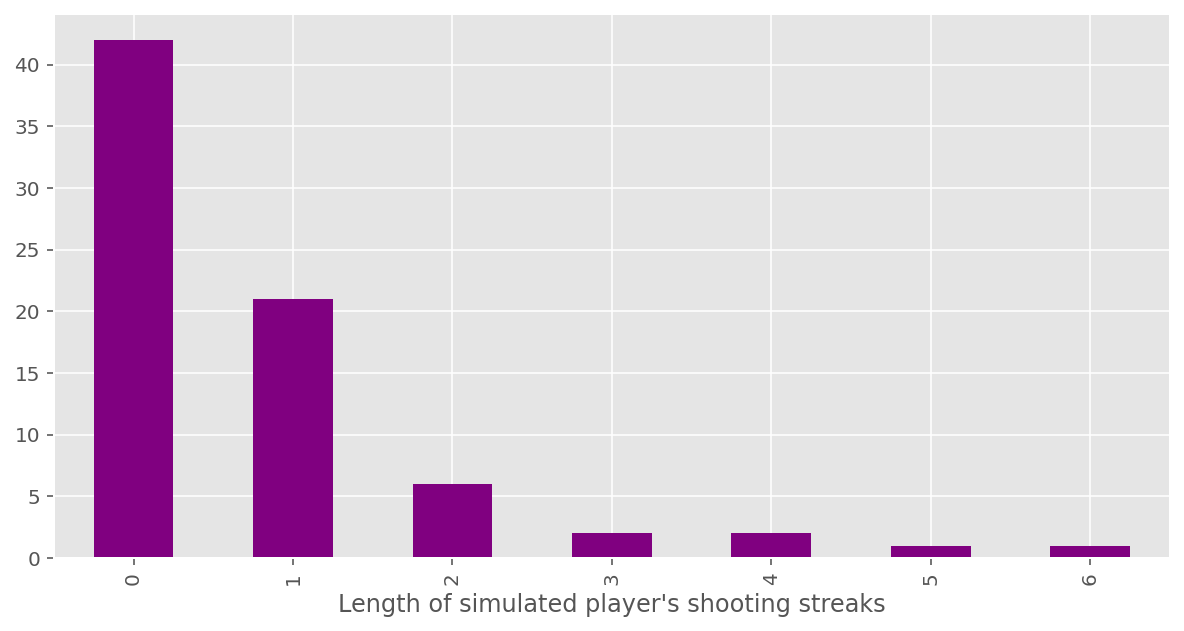

In [17]:
sim_streak_counts.plot(kind='bar', color='purple')
plt.xlabel("Length of simulated player's shooting streaks")
plt.show();

_2. If you were to run the simulation of the independent shooter a second time, how would you expect its streak distribution to compare to the distribution from the question above? Exactly the same? Somewhat similar? Totally different? Explain your reasoning._

_If I were to run the simulation a second time, i.e. get a new `sim_basket`, then derive `sim_streak` from that, analyze & plot the results in a bar chart, then the streak distribution should be similar. It will most likely not be the same, since getting the exact sequence of H's and M's, in the order previously seen, would be highly unlikely. As a consequence, the streak lengths will change from what they were in the last simulation._

_Also, because the highest streak length observed, of eight, had only very few observations, then this streak length will very likely not be present in the next simulation (possibly to be replaced by a shorter, or a longer, streak length instead.)_

_3. How does Kobe Bryant's distribution of streak lengths compare to the distribution of streak lengths for the simulated shooter? Using this comparison, do you have evidence that the hot hand model fits Kobe's shooting patterns? Explain._

#### Take 1.

The idea of the following cell is to run many simulations of what a "non-streaky" basketball player (for whom the probability of landing every shot is totally independent of having landed any prior shot(s).) Having done so, we can then calculate for each simulation the list of streaks that resulted.

In [18]:
# Make a callable method to get a random simulation of 133 shots being made
# by a 'non-streaky' simulated basketball player
def get_sim_basket():
    outcomes = ['H', 'M']
    sim_result = np.random.choice(
        outcomes, size = 133, replace = True, p = [0.45, 0.55])
    return sim_result

# Run many simulations, e.g. n = 5000
sims_5000 = [get_sim_basket() for _ in range(5000)]

# Get streak lists for ea. simulation
sim_streaks_5000 = [calc_streak(sim) for sim in sims_5000]

Now, out of 5000 simulations, take the mean & standard deviation of all streak lengths:

* _take each resulting list of streak lengths_
* _build a dataframe consisting of_ one column, _for streak length, and having a_ multi-index _made out of simulation number & streak number_
* _then just compute summary statistics based upon that series (single column.)_

In [19]:
# To go with this approach, *don't* do value_counts to sum 
# up num. of streaks by streak length, within each streak-list

# Try it this way:
sim_streakses_5000 = [
    pd.Series(streaks,
              name='sim_streaks_'+str(j))
    for j, streaks in enumerate(sim_streaks_5000)]

# e.g.
# print(sim_streakses_5000[3])

# What does the data frame made from this
# list-of-streaks look like?
df_streaks = pd.DataFrame(sim_streakses_5000)
# 'df_streaks' is now a dataframe having one row per simulation,
# and listing out in up to 91 columns the streak length for each
# observed streak (with 'Nan' values after the last streak to take place.)

# get just one column, multiindexed
df_all_streaks = df_streaks.stack()
df_all_streaks

sim_streaks_0     0     8.0
                  1     0.0
                  2     4.0
                  3     0.0
                  4     0.0
                       ... 
sim_streaks_4999  67    1.0
                  68    0.0
                  69    0.0
                  70    0.0
                  71    1.0
Length: 368550, dtype: float64

In [20]:
# As a sanity check, the length of 'df_all_streaks'
# should equal the sum of all series lengths in 'sim_streakses_5000'
length1 = sum(len(series) for series in sim_streakses_5000)
print(length1) 

length2 = len(df_all_streaks)
print(length2) 

length1 == length2

368550
368550


True

In [21]:
# Now, summarize 'df_all_streaks to'
# 1. get mean & standard deviation
# 2. compare vs. 'pd.Series(kobe_streak)' 
#    (not interested in the value_counts based on this)
df_all_streaks.describe()

count    368550.000000
mean          0.810506
std           1.209436
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          17.000000
dtype: float64

In [22]:
kobe_streaks = pd.Series(kobe_streak)
kobe_streaks.describe()

count    76.000000
mean      0.763158
std       0.991543
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       4.000000
dtype: float64

The mean streak length observed across 5000 simulations was about 0.81 with a standard deviation of 1.21, whereas (looking at Kobe's derived streak-lengths time series) Kobe had a mean streak length of 0.76 with a standard deviaton of 0.99. Kobe's average streak length is not evidently different from that of our simulated "non-streak-y" basketball player, and (in terms of standard deviation) a majority of Kobe's variability in streak length lies about as close to the mean as for the simulated player. So this data doesn't support the "hot hand" hypothesis, for this dataset.

#### Take 2.

I'm not sure whether running 5000 simulated sequences (of 133 throws each), getting the streak series for each simulation, then 'stacking' all of these outcomes like one variable with thousands of observations is a statistically reasonable procedure.

Instead - use these 5000 observations to work out a sort of aggregate "portrait" of an average game: that is,

1. Do the `value_counts()` for each pd.Series in the list of simulations to be put together, then
2. Assemble the data frame that is indexed on the simulation number, where each column corresponds to a streak length & the entry at `df.loc[j, k]` is the number of streaks during simulation #j of length: k
3. Get the average value for each column. The resulting pd.Series would be indexed by _streak lengths_, and have _average frequencies_ (non-normalized) for each possible streak length.
4. Turn this probability distribution into expected (average) streak length & standard deviation.

4 is the part that I need to think about how to do using pandas (unsure how at present.)

In [23]:
# As before, 'sim_streaks_5000' is a list whose j'th entry 
# sim_streaks_5000[j] is a list of streak lengths, in the order
# in which they occurred during simulation #j

# Get the value counts for every simulation's derived streaks t-series
sim_value_counts_5000 = [
    pd.Series(streaks)
            .value_counts()
            .sort_index()
    for streaks in sim_streaks_5000
]

# check some data
print(sim_value_counts_5000[0])
print(sim_value_counts_5000[50])

0    38
1    23
2     4
3     3
4     2
6     1
8     1
dtype: int64
0    28
1    15
2    14
3     5
4     1
8     1
dtype: int64


What does the index look like for a typical entry in the list `sim_value_counts_5000` (i.e. a typical pd.Series of streak lengths)?

In [24]:
sim_value_counts_5000[50].index

Int64Index([0, 1, 2, 3, 4, 8], dtype='int64')

It's precisely the (observed) streak lengths which arose during simulation #j (`j: 50` in the example above.)

In [25]:
# Create the dataframe
df_value_counts = pd.DataFrame(sim_value_counts_5000)

# Compare first 5 observations in the dataframe
df_value_counts.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,38.0,23.0,4.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50.0,14.0,8.0,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,43.0,13.0,8.0,4.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23.0,20.0,14.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34.0,16.0,13.0,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# vs. the first 5 pd.Series in 'sim_value_counts_5000'
for srs in sim_value_counts_5000[:5]:
    print(srs)

0    38
1    23
2     4
3     3
4     2
6     1
8     1
dtype: int64
0    50
1    14
2     8
3     2
4     1
5     3
dtype: int64
0    43
1    13
2     8
3     4
4     2
5     1
7     1
dtype: int64
0    23
1    20
2    14
3     6
4     1
dtype: int64
0    34
1    16
2    13
3     3
4     2
5     1
dtype: int64


(For each observation, any streak length in the superset of all pd.Series indices which did _not_ arise for that observation simply get 'NaN'. It would be appropriate in this setting to just fill these in with 0's, because precisely 0 instances of that streak length arose in this context.)

In [27]:
df_value_counts.fillna(0.0, inplace=True)
df_value_counts.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,38.0,23.0,4.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50.0,14.0,8.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43.0,13.0,8.0,4.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23.0,20.0,14.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34.0,16.0,13.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, for instance, we can find out what the _average number of occurrences_ for length-4 streaks was, for our round of 5000 simulations:

In [28]:
df_value_counts[4].mean()

1.645

In [29]:
# Proceed to do so for *all* streak lengths
val_count_means = df_value_counts.mean()
print(val_count_means)

# Note that this is a pd.Series
print(type(val_count_means))

0     40.5992
1     18.3790
2      8.1620
3      3.6264
4      1.6450
5      0.7096
6      0.3156
7      0.1492
8      0.0684
9      0.0292
10     0.0154
11     0.0062
12     0.0026
13     0.0012
14     0.0004
15     0.0002
16     0.0002
17     0.0002
dtype: float64
<class 'pandas.core.series.Series'>


Conceptually, then, we have transformed our original simulated dataset of 5000 "games" (each game = an array of 133 attempted throws, with probability for each to land being totally independent of all other throws) into a simulated "average game"'s value counts (i.e. for each streak length, the number of times that it arises _on average._) 

However, we **don't** want the mean / standard deviation of these numbers! Instead, we want the mean / standard deviation of the variable that would result if each row's value were _weighted by its index_. This is because we want to "unpack" this average-game value-counts series into the "average game" itself.

In [30]:
df_val_count_means = val_count_means.to_frame(name='count')
# For convenience, we'll add a column that is essentially
# a copy of the index, but imbued with mathematical relevance
df_val_count_means['streak_length'] = df_val_count_means.index.to_series()
print(df_val_count_means)

      count  streak_length
0   40.5992              0
1   18.3790              1
2    8.1620              2
3    3.6264              3
4    1.6450              4
5    0.7096              5
6    0.3156              6
7    0.1492              7
8    0.0684              8
9    0.0292              9
10   0.0154             10
11   0.0062             11
12   0.0026             12
13   0.0012             13
14   0.0004             14
15   0.0002             15
16   0.0002             16
17   0.0002             17


Now create a new series to represent the "ensemble" of streak lengths observed in our composite "average simulation" (order is irrelevant for our purposes.)

In [31]:
from math import modf

# this is a sort of peculiar approximation to 'unpacking value counts
# back into a list of streaks', which deals with the fact that I cannot
# actually create e.g. 'a sublist consisting of 3.7108 length-3 streaks.'
# row[0]: 'count'; modf(row[0])[1] is the integral part,
#                  modf(row[0])[0] is the fractional part which I multiply
#                                  by row[1]: 'streak_length' and add as an extra entry
avg_sim_streaks = pd.concat(
    [pd.Series(  [row[1]] * int(modf(row[0])[1]) 
               + [row[1] * modf(row[0])[0]]
               , dtype='float64')  
         for row 
         in df_val_count_means.itertuples(index=False)],
    ignore_index=True)

avg_sim_streaks

0     0.0000
1     0.0000
2     0.0000
3     0.0000
4     0.0000
       ...  
83    0.0156
84    0.0056
85    0.0030
86    0.0032
87    0.0034
Length: 88, dtype: float64

In [32]:
# Now get the summary statistics of this "reconstructed average-game streaks t-series"
avg_sim_streaks.describe()

count    88.000000
mean      0.678891
std       0.962162
min       0.000000
25%       0.000000
50%       0.004500
75%       1.000000
max       4.000000
dtype: float64

In [33]:
kobe_streaks.describe()

count    76.000000
mean      0.763158
std       0.991543
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       4.000000
dtype: float64

Under this analysis, which works with a time series much closer to a reconstructed "typical game of basketball", Kobe's performance looks _even closer_ to that of a simulated player without hot hands!

#### Take 3.

The approach of "unpacking a value-counts pd.Series back into a typical average game" (up to permutation in the streak order) is still somewhat clumsy. Instead, just _directly reinterpret `df_val_count_means` into a dictionary_ and then write a Python function that will interpret this as a discrete probability distribution.

In [35]:
# Normalize counts to get probabilities
df_probs = df_val_count_means.copy()
df_probs['count'] = df_probs['count'] / df_probs['count'].sum()
df_probs.rename(columns={"count":"prob"}, inplace=True)

streak_len_prob_dist = [dict(zip(['j', 'P(X_j)', 'X_j'],
                                 list(row)))
                        for row in df_probs.itertuples()]

# Define functions to compute mean and std dev
def get_pdist_mean(prob_dist):
    '''
    Given a discrete probability distribution represented as a 
    list of dictionaries, return the mean (a.k.a. expected value) 
    of the distribution.
    '''
    return sum(d['P(X_j)'] * d['X_j'] for d in prob_dist)

streak_len_mean = get_pdist_mean(streak_len_prob_dist)
print("The mean streak length is:", streak_len_mean)

def get_pdist_var(prob_dist):
    '''
    Given a discrete probability distribution represented as a 
    list of dictionaries, return the variance of the distribution.
    '''
    pd_mean = get_pdist_mean(prob_dist)
    weight_sq_devs = [(d['X_j'] - pd_mean)**2 * d['P(X_j)']
                      for d in prob_dist]
    return sum(weight_sq_devs)

streak_len_var = get_pdist_var(streak_len_prob_dist)
print("The streak length variance is:", streak_len_var)

def get_pdist_std_dev(prob_dist):
    '''
    Given a discrete probability distribution represented as a 
    list of dictionaries, return the standard deviation of the 
    distribution.
    '''
    from math import sqrt
    pdist_var = get_pdist_var(prob_dist)
    return sqrt(pdist_var)

streak_len_stdev = get_pdist_std_dev(streak_len_prob_dist)
print("The streak length standard deviation is:", streak_len_stdev)

The mean streak length is: 0.8105060371727035
The streak length variance is: 1.462732656692626
The streak length standard deviation is: 1.2094348501232408


This gives a slightly different result from the approach used in Take 2, but I am inclined to view this one as more accurate.

<div class = "license">
This lab was adapted by Vural Aksakalli and Imran Ture from OpenIntro by Andrew Bray and Mine Çetinkaya-Rundel.
</div>

***
www.featureranking.com